# Linear regression with custom loss function
For certain prediction problems it may be desirable to define a custom loss function for model training. For illustration purpose, let's use the following simple loss function which features symmetric loss (standard OLS regression) for $\alpha=0$ as well as asymmetric loss for $\alpha \neq 0$: 

$L(\hat{y} - y, \alpha) = (\hat{y} - y)^2 (sign(\hat{y} - y) + \alpha)^2$

where $y$ is the true outcome and $\hat{y}$ is the fitted value. This simple loss function can be interpreted as follows:

* $1 > \alpha > 0$: Higher loss on predictions above target 
* $0 > \alpha > -1$: Higher loss on predictions below target 
* $\alpha$ = 0: Symmetric loss


## Visualize custom loss function:

In [17]:
def custom_loss(error, alpha):
    return error**2 * (np.sign(error) + alpha)**2

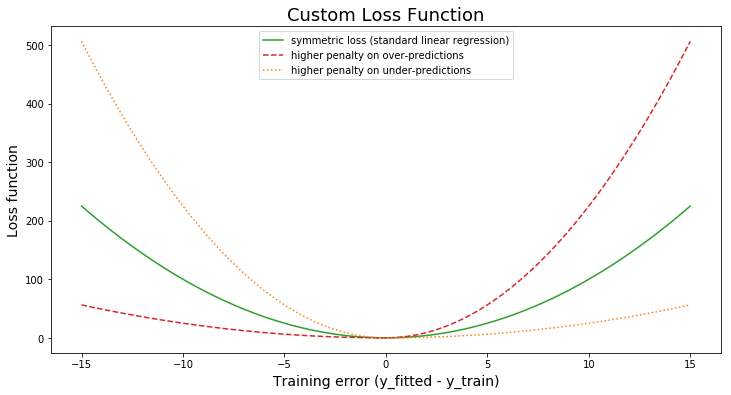

In [18]:
import pylab
import numpy as np
import pandas as pd

# define errors
error = numpy.linspace(-15,15,100)


pylab.figure(figsize=(12, 6))

# symmetric loss (standard linear regression)
alpha = 0
loss = custom_loss(error, alpha)
pylab.plot(error,loss, label='symmetric loss (standard linear regression)', color='tab:green') 

# higher penalty on over-predictions
alpha = 0.5
loss = custom_loss(error, alpha)
pylab.plot(error,loss, label='higher penalty on over-predictions', linestyle='--', color='tab:red') 

# higher penalty on under-predictions
alpha = -0.5
loss = custom_loss(error, alpha)
pylab.plot(error, loss, label='higher penalty on under-predictions', linestyle=':', color='tab:orange') 

pylab.xlabel('Training error (y_fitted - y_train)', fontsize=14)
pylab.ylabel('Loss function', fontsize=14)

pylab.title('Custom Loss Function', fontsize=18)

pylab.legend(loc='best')
pylab.show() # show the plot

## Load example dataset
Let's load a random time series from the Kaggle Rossmann Stores Sales dataset to illustrate the concept. The time series is augmented by some features that are useful for forecasting future sales volume, including day-of-week and monthly dummies as well as a dummy for sales promotions. In addition, a 1-day lag and a 5-day moving average (lagged by one day) of the target variable are included. 

Note that the objective of this exercise is to illustrate a linear regression with a custom loss function and, thus, the goal is not to come up with the best possible model or feature set for optimizing predictive accuracy.     

In [24]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

features = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa',
           'Feb','Mrz','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez',
           'Promo',
           'mav_5d',
           'lag_1d']

X_train = df_train[features]
X_test = df_test[features]
y_train = df_train['Sales']
y_test = df_test['Sales']

## Define custom loss and objective function for linear regression: 

In [25]:
from scipy.optimize import minimize

def custom_loss(y_train, y_fitted, alpha):
    return np.sqrt(np.mean((y_fitted - y_train)**2 * (np.sign(y_fitted - y_train) + alpha)**2))

def objective_function(beta, X_train, y_train, alpha):
    error = custom_loss(y_train, np.matmul(X_train,beta), alpha)
    return(error)

## Minimizing the objetive function for different $\alpha$ values:

In [26]:
############################################ CASE 1: alpha=0 ##################################################################
# initialize the parameter search space
alpha = 0
beta_init = np.array([1]*X_train.shape[1])
result = minimize(objective_function, beta_init, args=(X_train, y_train, alpha),
                  method='BFGS', options={'maxiter': 500})

# parameters
beta_hat = result.x
# predict on test set
y_pred_1 = np.matmul(X_test.values,beta_hat)

############################################ CASE 2: alpha=0.5 #################################################################
alpha = 0.5
beta_init = np.array([1]*X_train.shape[1])
result = minimize(objective_function, beta_init, args=(X_train, y_train, alpha),
                  method='BFGS', options={'maxiter': 500})

# parameters
beta_hat = result.x
# predict on test set
y_pred_2 = np.matmul(X_test.values,beta_hat)

# save predictions to pandas dataframe
ts = pd.DataFrame({'y_pred_1': y_pred_1, 
                   'y_pred_2': y_pred_2,
                   'y_test': y_test.values}, 
                   index = df_test['date'])

## Compute score on test set for $\alpha$ = 0.5:

In [27]:
print('Test set score for model training under symmetric loss (alpha = 0): ' + str(round(custom_loss(ts.y_test, ts.y_pred_1, 0.5),2)))
print('Test set score for model training under asymmetric loss (alpha = 0.5): ' + str(round(custom_loss(ts.y_test, ts.y_pred_2, 0.5),2)))


Test set score for model training under symmetric loss (alpha = 0): 1146.28
Test set score for model training under asymmetric loss (alpha = 0.5): 946.59


As expected, the second model performs better since it puts a higher penalty on over-predictions during model training. Finally, let's plot the true values and predictions on the test set:

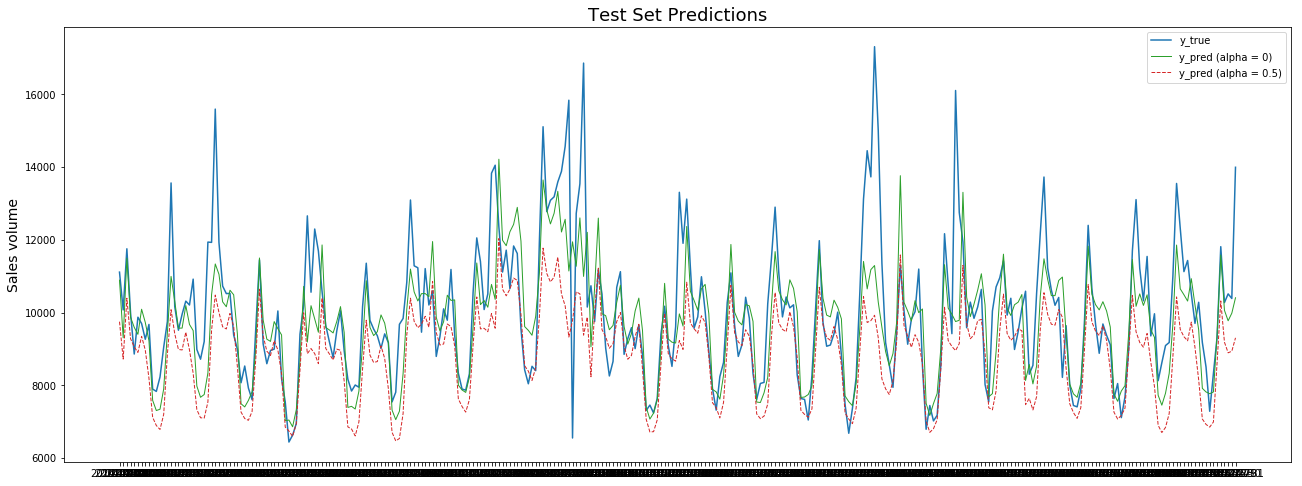

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 8))

plt.plot(ts.index, ts[['y_test']], linewidth=1.5, label='y_true', color='tab:blue')
plt.plot(ts.index, ts[['y_pred_1']], linewidth=1, label='y_pred (alpha = 0)', color='tab:green')
plt.plot(ts.index, ts[['y_pred_2']], linewidth=1, label='y_pred (alpha = 0.5)', color='tab:red', linestyle='--')
plt.legend(loc='best')

plt.ylabel('Sales volume', fontsize=14)
plt.title('Test Set Predictions', fontsize=18)

plt.show()